<a href="https://colab.research.google.com/github/ekateee/parser/blob/main/parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install beautifulsoup4 requests

In [ ]:
from bs4 import BeautifulSoup
from google.colab import drive
drive.mount('/content/drive/')
import requests
import json
import re
import os
import pandas as pd

headers = requests.utils.default_headers()
headers.update({ 'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/69.0'})

Mounted at /content/drive/


##Получение URLs страниц категорий

**Сбор текстов** из статей в качестве датасета.

Данные берутся с сайта **https://www.newsru.com**

По 4 категориям:
1. Авто
2. Технологии
3. Недвижимость
4. Спорт


###Не используется

*для себя*

In [ ]:
def get_urls(url,name,n,first):
  for i in range(first,n+1,1):
    name_file = '/content/drive/MyDrive/urls_' + str(name) + '.txt'
    with open(name_file,mode='a') as file:
      file.write(url + str(i) + '/'+ '\n')
    

In [ ]:
# get_urls('https://www.newsru.com/dossiers/30836/','пандемия',49,1)
# get_urls('https://www.newsru.com/dossiers/30/','криминал',60,1)
# get_urls('https://www.newsru.com/dossiers/154/','религия',60,1)
# get_urls('https://www.newsru.com/dossiers/30836/','пандемия',60,51)

###Используется

In [ ]:
def get_urls_for_data(array_data,category,url,main_info):
  for i in array_data:
    name_file = main_info + str(category) + '.txt'
    with open(name_file, mode='a') as file:
      file.write(url + str(i) + '\n')

In [ ]:
array_month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','okt','nov','dec']
array_years = ['2019/','2020/']
array_data = [str(data) + month + year  for year in array_years for month in array_month  for data in range(1,30) ]

get_urls_for_data(array_data,'авто','https://www.newsru.com/auto/','/content/drive/MyDrive/urls_' )
get_urls_for_data(array_data,'технологии','https://www.newsru.com/hitech/','/content/drive/MyDrive/urls_' )
get_urls_for_data(array_data,'недвижимость','https://www.newsru.com/realty/','/content/drive/MyDrive/urls_' )
get_urls_for_data(array_data,'спорт','https://www.newsru.com/sport/','/content/drive/MyDrive/urls_' )


###Для тестовой выборки

In [ ]:
array_month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','okt','nov','dec']
array_years = ['2018/']
array_data = [str(data) + month + year  for year in array_years for month in array_month  for data in range(1,30) ]

get_urls_for_data(array_data,'авто','https://www.newsru.com/auto/','/content/drive/MyDrive/urls_test_' )
get_urls_for_data(array_data,'технологии','https://www.newsru.com/hitech/','/content/drive/MyDrive/urls_test_' )
get_urls_for_data(array_data,'недвижимость','https://www.newsru.com/realty/','/content/drive/MyDrive/urls_test_' )
get_urls_for_data(array_data,'спорт','https://www.newsru.com/sport/','/content/drive/MyDrive/urls_test_' )

##Запись в файл

In [ ]:
def writing_to_file(path,category,headers,storage):
  main = 'https://www.newsru.com'
  path = main + path 
  request = requests.get(path, headers)
  soup = BeautifulSoup(request.content, 'html.parser')

  title = soup.title.get_text().replace('NEWSru.com :: ','')
  try:
    result = soup.find_all('meta', attrs={'name': 'news_keywords'})
    keywords = str(result[0]).replace('\n','').replace('" name="news_keywords"/>','').replace('<meta content="','')  
    tags = []
    word = ' '
    for i in range(len(keywords)):
      if keywords[i] != ',':
        word = word + keywords[i] 
      elif keywords[i]  ==',':
        tags.append(word)
        word =''
    tags.append(word)
    tags = [i[1:] for i in tags]
  except:
    tags = []

  try:
    text=''
    news = soup.find('div',attrs={'class':'article-text'})
    for script in news(["script", "style","center","img"]):                   
      script.decompose()   
    text =  news.get_text().replace('\n','')  
    if  text =='':
      exit()
  
    name_storage = '/content/drive/MyDrive/'+ storage + '.json'
    with open(name_storage,'a') as file:
      file.write(json.dumps({
          "link": path,
          "title": title,
          "category": category,
          "tags": tags,
          "text": text
          }, ensure_ascii = False) + '\n')
  except:
    exit()
  

##Получение URLs статей

In [ ]:
def get_urls_article(url, headers):
  request= requests.get(url, headers)
  soup = BeautifulSoup(request.content, 'html.parser')
  find_link = soup.find_all(href = re.compile(".html$"))
  urls = []
  for link in find_link:
      urls.append(link.get('href'))
  urls =  list(set(urls)) 
  return  urls 


##Main

In [ ]:
def open_file(path,category):
  with open(path,'r') as file:
    lines = file.readlines()[:-1]
  urls =[]
  for i in lines:
    urls_articles = get_urls_article(i,headers) 
    for j in urls_articles:
      urls.append(j)
  urls =  list(set(urls)) 
  name_file = '/content/drive/MyDrive/urls_acticles_' + str(category) + '.txt'
  with open(name_file, mode='a') as file:
    for i in  urls:
      file.write(i + '\n')
  print(len(urls))

In [ ]:
open_file('/content/drive/MyDrive/urls_авто.txt','авто')
open_file('/content/drive/MyDrive/urls_недвижимость.txt','недвижимость') 
open_file('/content/drive/MyDrive/urls_спорт.txt','спорт') 
open_file('/content/drive/MyDrive/urls_технологии.txt','технологии') 

In [ ]:
def get_info(category,count):
  path = '/content/drive/MyDrive/urls_acticles_' + category +'.txt'
  with open(path, mode='r') as file:
    lines = file.readlines()[:count]
  for line in lines:
    writing_to_file(line, category, headers,'dataset')


In [ ]:
get_info('авто',1200)
get_info('спорт',1200)
get_info('технологии',1200)
get_info("недвижимость",1200)

##Выгрузка данных

In [ ]:
import pandas as pd
from google.colab import files
files.download('/content/drive/MyDrive/dataset.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Показ данных

In [ ]:
news=[]
with open('/content/drive/MyDrive/dataset.json','r') as file:
  for line in file:
    news.append(json.loads(line[:-1]))
df = pd.DataFrame(news)
df.head()

,link,title,category,tags,text
0,https://www.newsru.com/auto/18May2020/911_targ...,Porsche представила обновленную модель 911 Tar...,авто,"[Porsche, Porsche 911 Targa, презентация]",Компания Porsche официально представила спортк...
1,https://www.newsru.com/auto/16Mar2020/rsa_to.h...,Минэкономики подготовило правила контроля опер...,авто,[],Минэкономики направило в правительство проект ...
2,https://www.newsru.com/auto/02Nov2020/epts.html\n,После череды отсрочек Россия перешла на электр...,авто,"[Россия, ЕАЭС, ЭПТС, водители]","С 1 ноября все автомобили, поставляемые в Росс..."
3,https://www.newsru.com/auto/26Dec2019/rivian_t...,"Электропикап Rivian получил ""танковый режим"", ...",авто,[],Американский стартап Rivian опубликовал на сво...
4,https://www.newsru.com/auto/15May2020/avtovaz_...,"""АвтоВАЗ"" возобновит производство с 18 мая",авто,"[АвтоВАЗ, автопром, возобновление производства]","Компания ""АвтоВАЗ"" подтвердила планы с 18 мая ..."


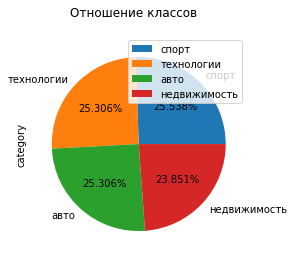

In [ ]:
cirle_diagrama = df["category"].value_counts().plot.pie(subplots = True, legend = True, autopct = '%2.3f%%', title = "Отношение классов")


In [ ]:
df = df['category'].value_counts().reset_index()
df.columns = ['category', 'count']
print (df)

       category  count
0         спорт   1211
1    технологии   1200
2          авто   1200
3  недвижимость   1131
